In [41]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import DenseNet121
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, accuracy_score
import joblib
from PIL import Image
import matplotlib.pyplot as plt

In [42]:
!git clone "https://github.com/Limteckping45/COS30019Assignment2"

fatal: destination path 'COS30019Assignment2' already exists and is not an empty directory.


In [43]:
train_data_dir = "/content/COS30019Assignment2/training_dataset"
test_data_dir = "/content/COS30019Assignment2/testing_dataset"
validation_data_dir = "/content/COS30019Assignment2/validation_dataset_1"

In [44]:
# Define image dimensions
img_width, img_height = 224, 224
input_shape = (img_width, img_height, 3)
batch_size = 32

In [45]:
# Pre-process and augment data
datagen = ImageDataGenerator(rescale=1./255)

train_generator = datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode="categorical",
    shuffle=False
)

test_generator = datagen.flow_from_directory(
    test_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode="categorical",
    shuffle=False
)

validation_generator = datagen.flow_from_directory(
    validation_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode="categorical",
    shuffle=False
)

Found 1920 images belonging to 12 classes.
Found 1200 images belonging to 12 classes.
Found 120 images belonging to 12 classes.


In [46]:
# Load pre-trained DenseNet121 model without top layers
base_model = DenseNet121(weights="imagenet", include_top=False, input_shape=input_shape)

In [47]:
# Extract features from train, validation, and test data
def extract_features(generator, sample_count):
    features = np.zeros(shape=(sample_count, 7, 7, 1024))  # DenseNet121 output shape
    labels = np.zeros(shape=(sample_count, generator.num_classes))

    i = 0
    for inputs_batch, labels_batch in generator:
        features_batch = base_model.predict(inputs_batch)
        features[i * batch_size : (i + 1) * batch_size] = features_batch
        labels[i * batch_size : (i + 1) * batch_size] = labels_batch
        i += 1
        if i * batch_size >= sample_count:
            break

    return features, labels

train_features, train_labels = extract_features(train_generator, train_generator.samples)
validation_features, validation_labels = extract_features(validation_generator, validation_generator.samples)
test_features, test_labels = extract_features(test_generator, test_generator.samples)

1/1 [==============================] - 0s 38ms/step


In [48]:
# Flatten extracted features
train_features = np.reshape(train_features, (train_generator.samples, 7 * 7 * 1024))
validation_features = np.reshape(validation_features, (validation_generator.samples, 7 * 7 * 1024))
test_features = np.reshape(test_features, (test_generator.samples, 7 * 7 * 1024))

In [49]:
# Convert labels from one-hot encoding to label encoding
train_labels = np.argmax(train_labels, axis=1)
validation_features = np.reshape(validation_features, (validation_generator.samples, 7 * 7 * 1024))
test_labels = np.argmax(test_labels, axis=1)

In [50]:
# Train KNN
knn_model = KNeighborsClassifier(n_neighbors=5)
knn_model.fit(train_features, train_labels)

KNeighborsClassifier()

In [51]:
# Save the KNN model
joblib.dump(knn_model, 'knn_animal_breed_classifier.pkl')

['knn_animal_breed_classifier.pkl']

In [52]:
# Predict training data using the trained KNN model
train_predictions = knn_model.predict(train_features)

# Calculate the training accuracy
train_accuracy = accuracy_score(train_labels, train_predictions)
print("Training Accuracy:", train_accuracy)

# Print the classification report for the training data
print(classification_report(train_labels, train_predictions, target_names=train_generator.class_indices.keys()))


Training Accuracy: 0.9380208333333333
               precision    recall  f1-score   support

       bengal       0.95      0.93      0.94       160
        boxer       0.97      0.91      0.94       160
    chihuahua       0.99      0.96      0.97       160
     havanese       0.98      1.00      0.99       160
japanese_chin       0.98      0.95      0.97       160
   maine_coon       0.78      0.96      0.86       160
      persian       0.97      0.89      0.93       160
          pug       0.91      1.00      0.96       160
      ragdoll       0.86      0.91      0.88       160
 russian_blue       0.97      0.94      0.95       160
saint_bernard       0.97      0.93      0.95       160
      siamese       0.99      0.89      0.94       160

     accuracy                           0.94      1920
    macro avg       0.94      0.94      0.94      1920
 weighted avg       0.94      0.94      0.94      1920



In [53]:
test_predictions = knn_model.predict(test_features)
test_accuracy = accuracy_score(test_labels, test_predictions)
print("Test Accuracy:", test_accuracy)
print(classification_report(test_labels, test_predictions, target_names=test_generator.class_indices.keys()))

Test Accuracy: 0.8441666666666666
               precision    recall  f1-score   support

       Bengal       0.86      0.91      0.88       100
        Boxer       0.98      0.80      0.88       100
    Chihuahua       0.99      0.89      0.94       100
     Havanese       1.00      0.99      0.99       100
Japanese Chin       1.00      0.96      0.98       100
   Maine Coon       0.53      0.86      0.66       100
      Persian       0.75      0.66      0.70       100
          Pug       0.87      0.99      0.93       100
      Ragdoll       0.71      0.71      0.71       100
 Russian Blue       0.80      0.75      0.77       100
Saint Bernard       0.95      0.99      0.97       100
      Siamese       0.95      0.62      0.75       100

     accuracy                           0.84      1200
    macro avg       0.87      0.84      0.85      1200
 weighted avg       0.87      0.84      0.85      1200



In [54]:
# Convert validation labels from one-hot encoding to label encoding
validation_labels = np.argmax(validation_labels, axis=1)

# Predict validation data using the trained KNN model
validation_predictions = knn_model.predict(validation_features)

# Calculate the validation accuracy
validation_accuracy = accuracy_score(validation_labels, validation_predictions)
print("Validation Accuracy:", validation_accuracy)

# Print the classification report for the validation data
print(classification_report(validation_labels, validation_predictions, target_names=validation_generator.class_indices.keys()))



Validation Accuracy: 0.9416666666666667
               precision    recall  f1-score   support

       bengal       0.91      1.00      0.95        10
        boxer       1.00      0.90      0.95        10
    chihuahua       1.00      0.90      0.95        10
     havanese       0.91      1.00      0.95        10
japanese_chin       1.00      0.90      0.95        10
   maine_coon       0.77      1.00      0.87        10
      persian       1.00      0.90      0.95        10
          pug       1.00      1.00      1.00        10
      ragdoll       0.89      0.80      0.84        10
 russian_blue       1.00      0.90      0.95        10
saint_bernard       0.91      1.00      0.95        10
      siamese       1.00      1.00      1.00        10

     accuracy                           0.94       120
    macro avg       0.95      0.94      0.94       120
 weighted avg       0.95      0.94      0.94       120



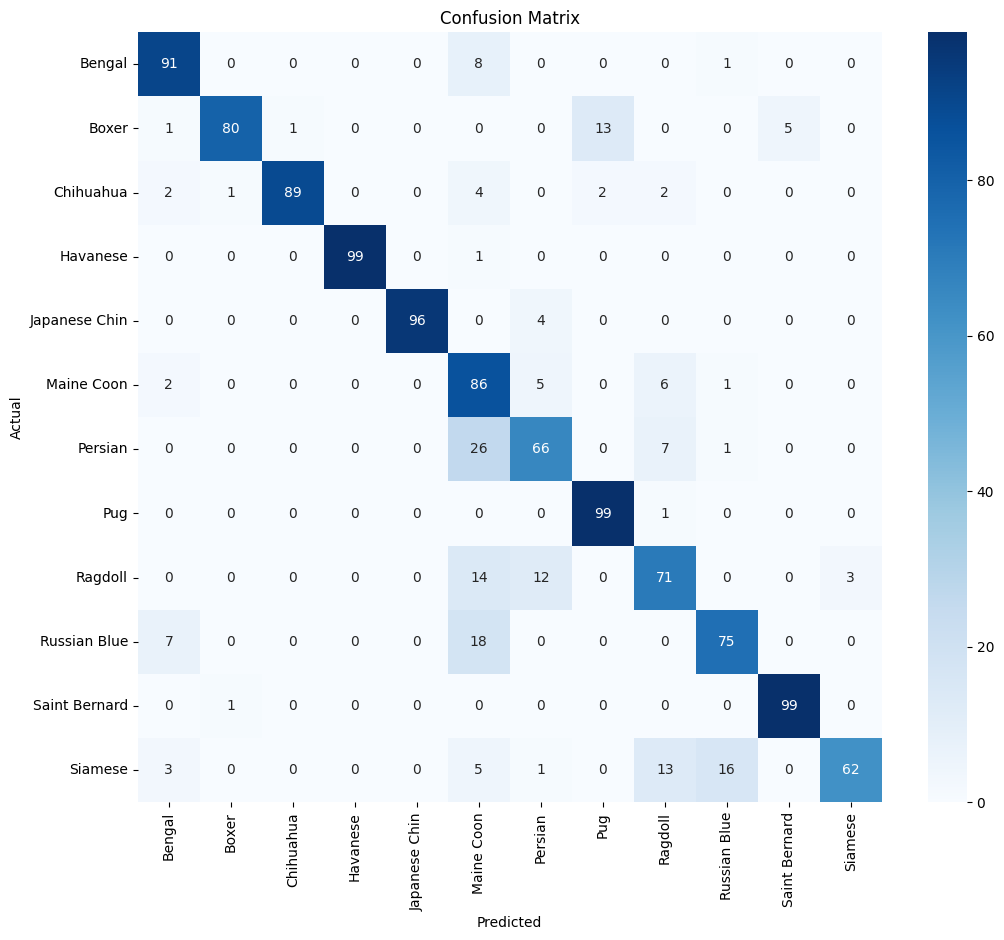

In [55]:
# Plotting confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

conf_matrix = confusion_matrix(test_labels, test_predictions)
plt.figure(figsize=(12, 10))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=test_generator.class_indices.keys(), yticklabels=test_generator.class_indices.keys())
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()

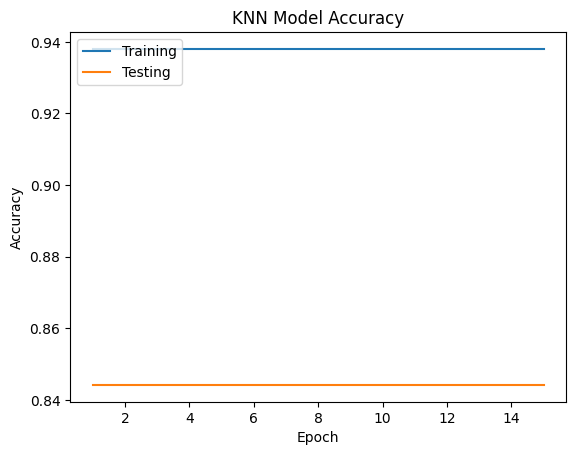

In [56]:
# Plot training and testing accuracy
epochs = range(1, 16)  # Assuming we want to plot for 15 epochs for visual purposes
train_accuracies = [train_accuracy] * len(epochs)
test_accuracies = [test_accuracy] * len(epochs)

plt.plot(epochs, train_accuracies, label='Training')
plt.plot(epochs, test_accuracies, label='Testing')
plt.title('KNN Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.show()

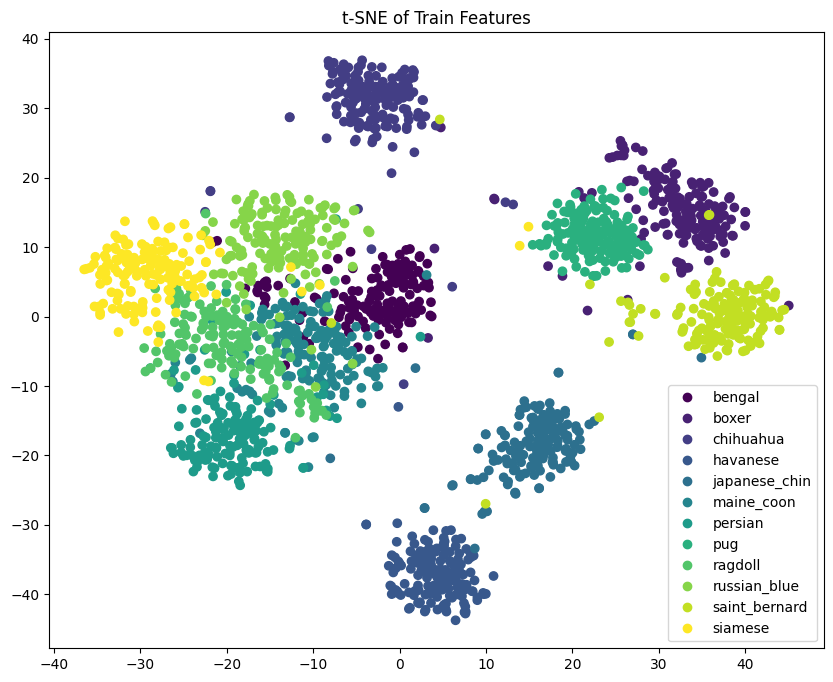

In [61]:
from sklearn.manifold import TSNE

# Fit and transform the features using t-SNE
tsne = TSNE(n_components=2, random_state=42)
train_features_tsne = tsne.fit_transform(train_features)

# Plot the t-SNE representation
plt.figure(figsize=(10, 8))
scatter = plt.scatter(train_features_tsne[:, 0], train_features_tsne[:, 1], c=train_labels, cmap='viridis')
plt.legend(handles=scatter.legend_elements()[0], labels=train_generator.class_indices.keys())
plt.title('t-SNE of Train Features')
plt.show()

In [57]:
# Load and preprocess images for feeding into a neural network model
def load_image(image_path, target_size=(224, 224)):
    img = image.load_img(image_path, target_size=target_size)
    image_tensor = image.img_to_array(img)
    image_tensor = np.expand_dims(image_tensor, axis=0)
    image_tensor /= 255.0
    return image_tensor

In [58]:
# Generate a list of random image paths from a given directory
def get_random_images(data_directory, number_images=10):
    testing_image_paths = []
    for curDir, subDirs, files in os.walk(data_directory):
        for file in files:
            if file.lower().endswith((".png", ".jpg", ".jpeg")):
                testing_image_paths.append(os.path.join(curDir, file))

    # Selecting images based on specified file extensions
    random_images = np.random.choice(testing_image_paths, number_images, replace=False)
    return random_images

In [59]:
# Display images with predicted breed
def display_image_with_breed(image_path, predicted_breed):
    img = Image.open(image_path)
    img = img.resize((600, 600))
    plt.figure(figsize=(3, 3))
    plt.imshow(img)
    plt.axis("off")
    plt.title(f"Predicted Breed: {predicted_breed}")
    plt.show()

1/1 [==============================] - 0s 48ms/step


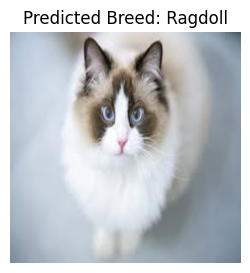

1/1 [==============================] - 0s 44ms/step


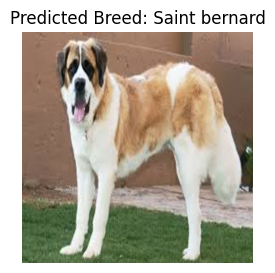

1/1 [==============================] - 0s 56ms/step


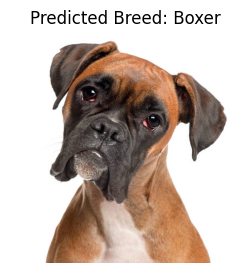

1/1 [==============================] - 0s 33ms/step


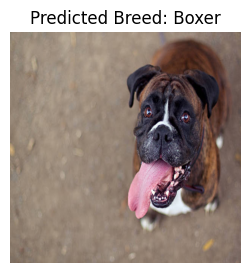

1/1 [==============================] - 0s 27ms/step


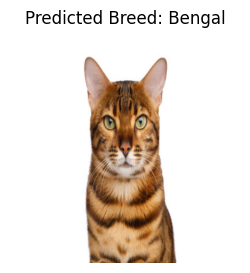

1/1 [==============================] - 0s 34ms/step


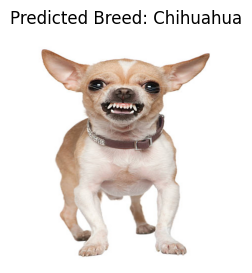

1/1 [==============================] - 0s 32ms/step


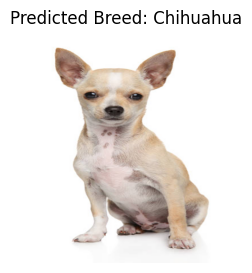

1/1 [==============================] - 0s 46ms/step


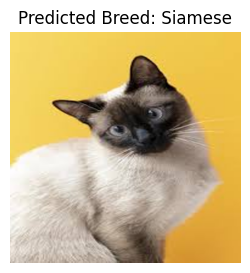

1/1 [==============================] - 0s 31ms/step


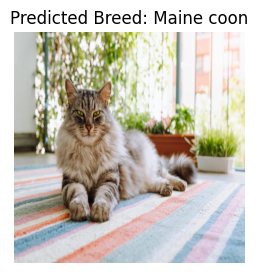

1/1 [==============================] - 0s 40ms/step


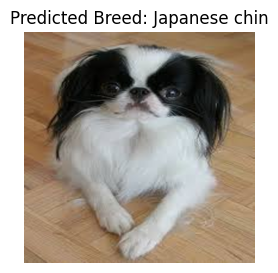

In [60]:
# Load random images from the validation dataset
random_images = get_random_images(validation_data_dir)
for image_path in random_images:
    new_image = load_image(image_path)

    # Extract features from the new image using the base model
    features = base_model.predict(new_image)
    features = np.reshape(features, (1, 7 * 7 * 1024))

    # Predict the breed of each image using the trained KNN model
    breed = knn_model.predict(features)

    # Display the predicted breed along with the image
    predicted_breed = list(train_generator.class_indices.keys())[breed[0]].replace("_", " ").capitalize()

    display_image_with_breed(image_path, predicted_breed)